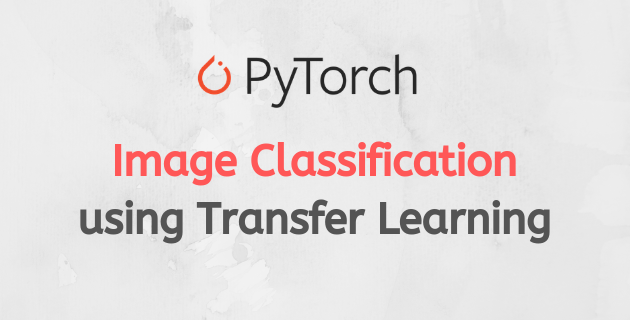

## PyTorch is an open source machine learning library based on the Torch library, used for applications such as computer vision and natural language processing, primarily developed by Facebook's AI Research lab.

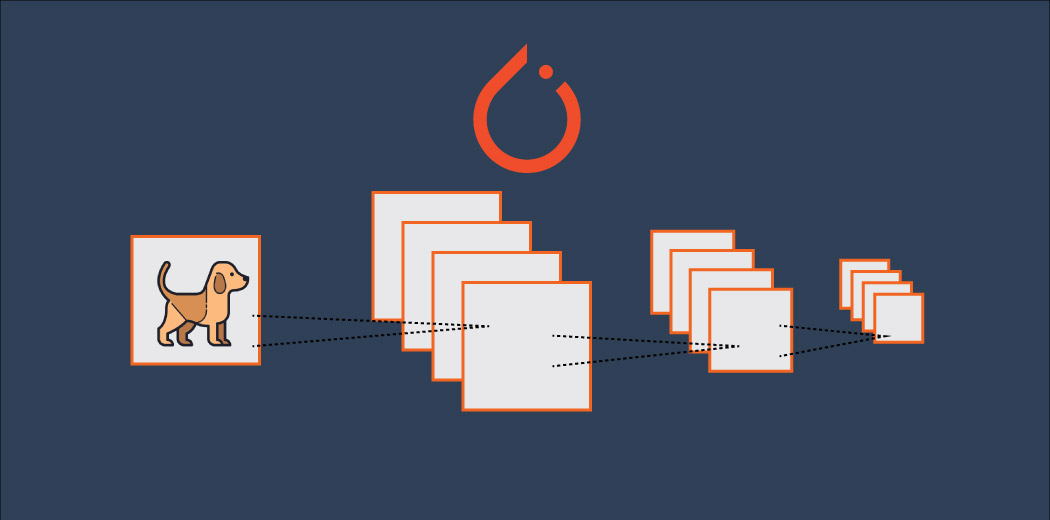

## Import all dependencies

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torchvision.datasets as datasets # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms # Transformations we can perform on our dataset
import torch.nn.functional as F # All functions that don't have any parameters
from torch.utils.data import DataLoader, Dataset # Gives easier dataset managment and creates mini batches
from torchvision.datasets import ImageFolder
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
from PIL import Image

## Set device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use gpu or cpu

## train test split

In [ ]:
from sklearn.model_selection import train_test_split
dataset = ImageFolder("../input/cat-and-dog/training_set/training_set/")
train_data, test_data, train_label, test_label = train_test_split(dataset.imgs, dataset.targets, test_size=0.2, random_state=42)

# ImageLoader Class

class ImageLoader(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = self.checkChannel(dataset) # some images are CMYK, Grayscale, check only RGB 
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, item):
        image = Image.open(self.dataset[item][0])
        classCategory = self.dataset[item][1]
        if self.transform:
            image = self.transform(image)
        return image, classCategory
        
    
    def checkChannel(self, dataset):
        datasetRGB = []
        for index in range(len(dataset)):
            if (Image.open(dataset[index][0]).getbands() == ("R", "G", "B")): # Check Channels
                datasetRGB.append(dataset[index])
        return datasetRGB

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize([0.5]*3, [0.5]*3)
]) # train transform

test_transform = transforms.Compose([
    transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize([0.5]*3, [0.5]*3)
]) # test transform

train_dataset = ImageLoader(train_data, train_transform)
test_dataset = ImageLoader(test_data, test_transform)

# Data loader. Combines a dataset and a sampler, and provides an iterable over the given dataset.

## The DataLoader supports both map-style and iterable-style datasets with single- or multi-process loading, customizing loading order and optional automatic batching (collation) and memory pinning.

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

## Resnet50 Transfer learning technique

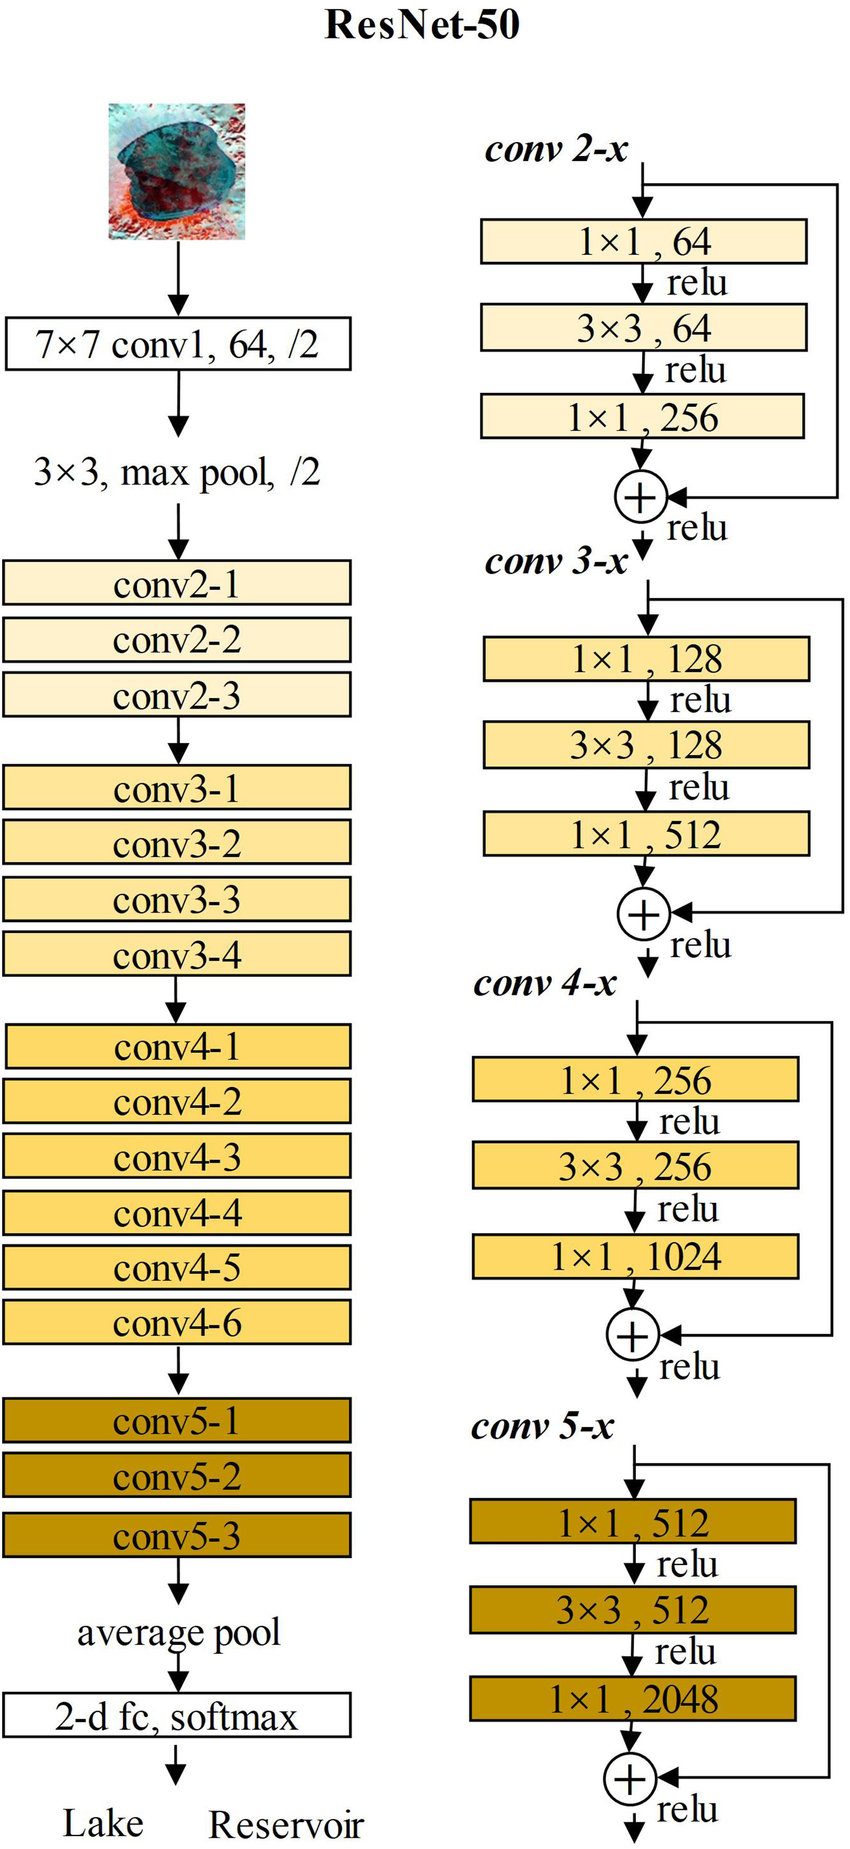

In [ ]:
from tqdm import tqdm
from torchvision import models
# load pretrain model and modify...
model = models.resnet50(pretrained=True)

# If you want to do finetuning then set requires_grad = False
# Remove these two lines if you want to train entire model,
# and only want to load the pretrain weights.

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model.to(device)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


# Train and test

def train(num_epoch, model):
    for epoch in range(0, num_epoch):
#         current_loss = 0.0
#         current_corrects = 0
        losses = []
        model.train()
        loop = tqdm(enumerate(train_loader), total=len(train_loader)) # create a progress bar
        for batch_idx, (data, targets) in loop:
            data = data.to(device=device)
            targets = targets.to(device=device)
            scores = model(data)
            
            loss = criterion(scores, targets)
            optimizer.zero_grad()
            losses.append(loss)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(scores, 1)
#             current_loss += loss.item() * data.size(0)
#             current_corrects += (preds == targets).sum().item()
#             accuracy = int(current_corrects / len(train_loader.dataset) * 100)
            loop.set_description(f"Epoch {epoch+1}/{num_epoch} process: {int((batch_idx / len(train_loader)) * 100)}")
            loop.set_postfix(loss=loss.data.item())
        
        # save model
        torch.save({ 
                    'model_state_dict': model.state_dict(), 
                    'optimizer_state_dict': optimizer.state_dict(), 
                    }, 'checpoint_epoch_'+str(epoch)+'.pt')


        
# model.eval() is a kind of switch for some specific layers/parts of the model that behave differently,
# during training and inference (evaluating) time. For example, Dropouts Layers, BatchNorm Layers etc. 
# You need to turn off them during model evaluation, and .eval() will do it for you. In addition, 
# the common practice for evaluating/validation is using torch.no_grad() in pair with model.eval() 
# to turn off gradients computation:
        
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            _, predictions = torch.max(output, 1)
            correct += (predictions == y).sum().item()
            test_loss = criterion(output, y)
            
    test_loss /= len(test_loader.dataset)
    print("Average Loss: ", test_loss, "  Accuracy: ", correct, " / ",
    len(test_loader.dataset), "  ", int(correct / len(test_loader.dataset) * 100), "%")

> CrossEntropy or other loss functions is divided by the number of elements i.e. the reduction parameter is mean by default.

*     torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')

> Hence, loss.item() contains the loss of entire mini-batch, but divided by the batch size. That's why loss.item() is multiplied with batch size, given by inputs.size(0), while calculating running_loss
> (stackoverflow)

In [ ]:
if __name__ == "__main__":
    train(5, model) # train
    test() # test

In [ ]:
print("----> Loading checkpoint")
checkpoint = torch.load("./checpoint_epoch_4.pt") # Try to load last checkpoint
model.load_state_dict(checkpoint["model_state_dict"]) 
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

In [ ]:
# Check the test set
dataset = ImageFolder("../input/cat-and-dog/test_set/test_set/", 
                     transform=transforms.Compose([
                         transforms.Resize((224, 224)), 
                         transforms.ToTensor(), 
                         transforms.Normalize([0.5]*3, [0.5]*3)
                     ]))
print(dataset)
dataloader = DataLoader(dataset, batch_size=1, shuffle = False)

In [ ]:
# for j, (data, labels) in enumerate(dataloader):
with torch.no_grad():
    model.eval()
    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)
        print(f"predicted ----> {predicted[0]}")

# create a function to predict random cats and dog images

In [ ]:
def RandomImagePrediction(filepath):
    img_array = Image.open(filepath).convert("RGB")
    data_transforms=transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.ToTensor(), 
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    img = data_transforms(img_array).unsqueeze(dim=0) # Returns a new tensor with a dimension of size one inserted at the specified position.
    load = DataLoader(img)
    
    for x in load:
        x=x.to(device)
        pred = model(x)
        _, preds = torch.max(pred, 1)
        print(f"class : {preds}")
        if preds[0] == 1: print(f"predicted ----> Dog")
        else: print(f"predicted ----> Cat")

In [ ]:
if __name__ == "__main__":
    RandomImagePrediction("../input/prediction-pytorch/dog/d41586-020-01430-5_17977552.jpg") # dog image
    RandomImagePrediction("../input/cat-and-dog/test_set/test_set/cats/cat.4011.jpg") # cat image
    RandomImagePrediction("../input/prediction-pytorch/dog/322868_1100-1100x628.jpg") # dog image